In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # need for file enumeration

# CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2,MobileNet,VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import utils,losses


# metrics
from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay, confusion_matrix

# For reproducibility
np.random.seed(42)

/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_results(history_,loss):
    if (loss=="loss"):        
        train_loss = history_.history['loss']
        test_loss = history_.history['val_loss']
        label="Loss"
    elif (loss=="accuracy"):
        train_loss = history_.history['accuracy']
        test_loss = history_.history['val_accuracy']
        label="Accuracy"
    
    epoch_labels = history_.epoch

    # Set figure size.
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs.
    plt.plot(train_loss, label=f'Training {label}', color='#185fad')
    plt.plot(test_loss, label=f'Testing {label}', color='orange')

    # Set title
    plt.title(f'Training and Testing {label} by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Categorical Crossentropy', fontsize=18)
    plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

    plt.legend(fontsize=18);

---
##### Data Acquisition

In [3]:
# load train images
train_path = '../project-5/data/seg_train/seg_train/'
train_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = train_datagen.flow_from_directory(
    train_path,
    target_size = (150, 150),
    batch_size = 15_000,
    class_mode = 'categorical')

X_train, y_train = itr.next()

Found 14034 images belonging to 6 classes.


In [4]:
# load validation images
val_path = '../project-5/data/seg_test/seg_test'
val_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = val_datagen.flow_from_directory(
    val_path,
    target_size = (150, 150),
    batch_size = 3_000,
    class_mode = 'categorical')

X_val, y_val = itr.next()

Found 3000 images belonging to 6 classes.


In [5]:
# load test images
test_path = '../project-5/data/seg_pred'
test_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = test_datagen.flow_from_directory(
    test_path,
    target_size = (150, 150),
    batch_size = 7_500,
    class_mode = None)

X_test = itr.next()

Found 7301 images belonging to 1 classes.


In [6]:
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [9]:
# quick-and-dirty auto-layout grid
# From Gabe's lab 9.2!
def display_images(images, labels, num_examples = 10, images_per_row = 4):
    '''
    Displays image data as a grid of images

    Parameters:
    - images (array): per-pixel image data
    - labels (array): corresponding labels for each image
    - num_examples (int): how many images to display, starting from element 0
    - images_per_row (int): how many images to include in each row of the display grid

    Displays:
    - auto-layout grid of requested images with labels
    '''
    total_rows = int(np.ceil(num_examples / images_per_row))
    fig, ax = plt.subplots(
        total_rows,
        images_per_row, figsize = (images_per_row * 2.5, total_rows * 2.5))
    for i in range(0, num_examples):
        row = int(i / images_per_row)
        col = i - (row * images_per_row)
        ax[row, col].axis('off')
        ax[row, col].set_title(labels[i])
        ax[row, col].imshow(images[i]);
    # delete any trailing empty subplots
    # https://stackoverflow.com/questions/44980658/remove-the-extra-plot-in-the-matplotlib-subplot
    for i in range(num_examples, total_rows * images_per_row):
        fig.delaxes(ax[total_rows - 1][i % images_per_row])
    fig.suptitle(f'First {num_examples} images');

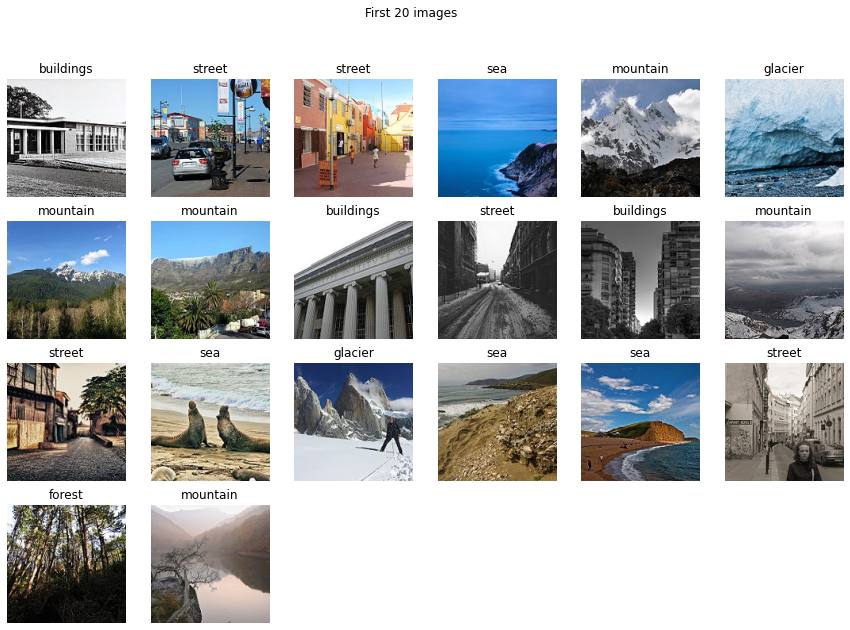

In [10]:
# let's see a few training examples!
display_images(X_train, [class_labels[np.argmax(y_train[i])] for i in range (0, len(y_train))],
    num_examples = 20, images_per_row = 6)

---
Modeling

In [11]:
def evaluate_models(models, histories, X_test, class_labels):
    '''
    Uses pre-compiled, pre-fit neural network classification models and their fit histories
    to generate useful statistics
    NOTE: assumes models were compiled with metrics including 'acc'

    Parameters:
    - models (list): list of pre-compiled, pre-fit models
    - histories (list): list of model histories - should be same length as models
    - X_test (array): test data of appropriate shape to make predictions on
    - class_labels (list): list of all possible class labels

    Displays:
    - Plots of confusion matrix, train/val loss over epochs, and test prediction counts

    Returns:
    - DataFrame containing model name, train/validation loss, train/validation accuracy
    '''

    assert type(models) == list
    assert type(histories) == list

    num_models = len(models)
    assert len(histories) == num_models

    model_stats = pd.DataFrame(columns = ['model_name', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

    fig = plt.figure(figsize = (20, num_models * 5.2))
    subfigs = fig.subfigures(num_models, wspace = 0.2, hspace = 0.2)
    if num_models == 1:
        subfigs = [subfigs]

    for i, model in enumerate(models):
        model_name = f'model {i}'

        train_loss = histories[i].history['loss']
        val_loss = histories[i].history['val_loss']
        train_acc = histories[i].history['acc']
        val_acc = histories[i].history['val_acc']

        # append our values to the stats dataframe
        model_stats.loc[len(model_stats)] = [model_name, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]]

        # display metrics
        # https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
        subfigs[i].suptitle(model_name)
        axs = subfigs[i].subplots(1, 3)

        # confusion matrix
        val_preds = np.array([np.argmax(x) for x in model.predict(X_val, verbose = 0)]).reshape(-1)
        true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
        axs[0].set_title('Confusion Matrix on Validation Set')
        ConfusionMatrixDisplay.from_predictions(true_preds, val_preds, display_labels = class_labels, ax = axs[0], xticks_rotation = 45)

        # performance of train vs val
        
        epoch_labels = histories[i].epoch
        axs[1].set_title(f'Loss by Epoch - Training vs. Validation')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel(model.loss)
        axs[1].set_xticks(epoch_labels, epoch_labels)
        axs[1].plot(train_loss, label = 'Training Loss', color = '#185fad')
        axs[1].plot(val_loss, label = 'Validation Loss', color = 'orange')
        axs[1].legend()
        
        # overview of test predictions
        test_class_probs = model.predict(X_test, verbose = 0)
        test_preds = [np.argmax(x) for x in test_class_probs]
        preds_df = pd.DataFrame([[class_labels[x], test_preds.count(x)]
            for x in set(test_preds)], columns = ['article', 'test_pred_count']).set_index('article')
        axs[2].set_title(f'Test Prediction Counts')
        preds_df.plot.barh(ax = axs[2])
        axs[2].get_legend().remove()

    return model_stats
        

In [17]:
# Pre-trained VGG19 model
pretrained_model = VGG19(input_shape=[150,150,3], include_top=False)
pretrained_model.trainable = True

In [21]:
model_trans=Sequential()
model_trans.add(pretrained_model)
model_trans.add(Flatten())

model_trans.add(Dense(128,activation="relu"))
model_trans.add(Dense(64,activation="relu"))
model_trans.add(Dense(6,activation="softmax"))
model_trans.compile(loss=losses.CategoricalCrossentropy(),optimizer='adam',metrics=['acc'])
history_cnn_trans=model_trans.fit(X_train,y_train,batch_size=128,validation_data=(X_val,y_val),epochs=10,verbose=1)


Epoch 1/10


2022-10-28 15:18:57.224701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 1.5389 - acc: 0.3308

2022-10-28 15:22:40.498611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 239s 2s/step - loss: 1.5389 - acc: 0.3308 - val_loss: 1.0324 - val_acc: 0.5667
Epoch 2/10
110/110 [==============================] - 230s 2s/step - loss: 1.0221 - acc: 0.5874 - val_loss: 0.8781 - val_acc: 0.6563
Epoch 3/10
110/110 [==============================] - 229s 2s/step - loss: 0.7910 - acc: 0.7041 - val_loss: 0.7393 - val_acc: 0.7247
Epoch 4/10
110/110 [==============================] - 228s 2s/step - loss: 0.6436 - acc: 0.7659 - val_loss: 0.5910 - val_acc: 0.7953
Epoch 5/10
110/110 [==============================] - 228s 2s/step - loss: 0.5485 - acc: 0.8013 - val_loss: 0.4742 - val_acc: 0.8367
Epoch 6/10
110/110 [==============================] - 227s 2s/step - loss: 0.4829 - acc: 0.8260 - val_loss: 0.4781 - val_acc: 0.8333
Epoch 7/10
110/110 [==============================] - 228s 2s/step - loss: 0.4516 - acc: 0.8406 - val_loss: 0.4529 - val_acc: 0.8417
Epoch 8/10
110/110 [==============================] - 228s 2s/step - loss: 0.414

2022-10-28 15:57:28.258086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


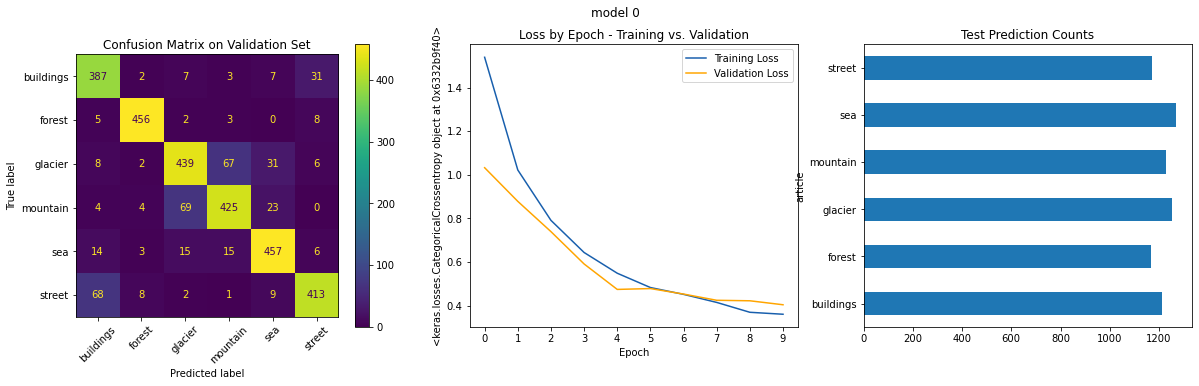

In [22]:
stats = evaluate_models([model_trans], [history_cnn_trans], X_test, class_labels)

In [23]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.36036,0.40389,0.871099,0.859


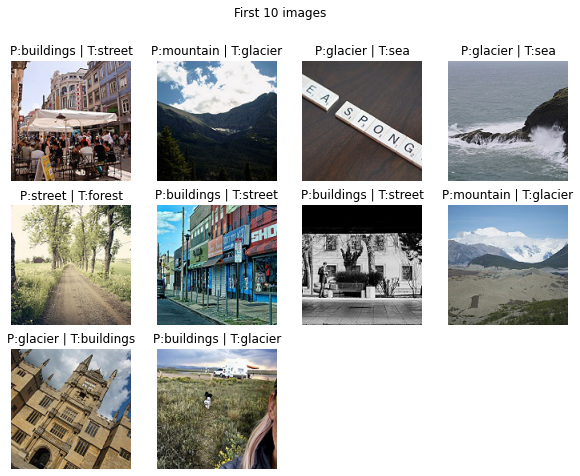

In [25]:
# just for fun, let's sample some of the confusion for the first model's validation set
# P indicates prediction, T indicates true value
val_preds = np.array([np.argmax(x) for x in model_trans.predict(X_val, verbose = 0)]).reshape(-1)
true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
mismatches = [i for i in range(0, len(val_preds)) if val_preds[i] != true_preds[i]]
display_images([X_val[i] for i in mismatches], [f'P:{class_labels[val_preds[i]]} | T:{class_labels[true_preds[i]]}' for i in mismatches])